# Honey Bees Classification Project

#### In this project we  worked with the Image data predicting the sub species  of the Bees and the health of the Bees.
#### This data set contains the following features:
* 'File': corresponds to the file name in the data set
* 'Date': Date when the picture was taken
* 'Time': Time when the individual picture was taken
* 'Location': Location of the picture 
* 'Zip Code': Zip code of the area where the picture was collected
* 'Subspecies': Subspecies of the different kinds of the Bees
* 'Health': Different health statuses of the Bees/Bee Hives
* 'Pollen Carrying': Whether or not pollen was carried by the Bee when the picture was taken
* 'Caste': Different castes of the Bees depending upon the responsibility assigned in the hive


In [1]:
# Imported General Libraries
import pandas as pd
import numpy as np
from numpy import array
import os
# For Image Processing
import imageio
import skimage
import skimage.io
import skimage.transform
from skimage.transform import rescale, resize, downscale_local_mean

# For Plotting graphs and visualization of data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
% matplotlib inline

# For splitting of data
import sklearn
from sklearn.model_selection import train_test_split
# for Modelling and Machine Learning
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense
from keras.preprocessing.image import ImageDataGenerator



C:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
"""
Read the data into a dataframe from a csv file and displayed the top 5 records
"""
Bees = pd.read_csv("bee_data.csv")
Bees.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [3]:
"""Shape of the Data; Data set had 5172 records and 9 attributes"""
Bees.shape

(5172, 9)

# Visualization of an Image

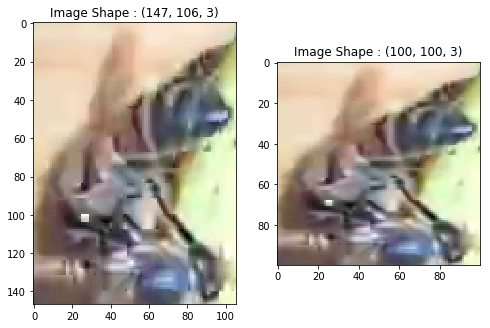

In [4]:
"""
Image transformation : An instance is shown below to show the comparison in the dimensions of an image from (147,106,3) to (100,100,3)
This has been done for all the images in the dataset to maintain the uniformity of the dimensions of each image. 
"""
img = "041_059.png"
img = skimage.io.imread("bee_imgs\\"+ img)
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.title('Image Shape : (%d, %d, %d)'% img.shape)
fig.add_subplot(1, 2, 2)
img = skimage.transform.resize(img, (100,100),mode = 'reflect')
plt.imshow(img)
plt.title('Image Shape : (%d, %d, %d)'% img.shape)
plt.show()


# Data Exploration

## Distribution of Bees by Categories

### Subplots plotted for Subspecies, Locations, Caste and Health of the Bees

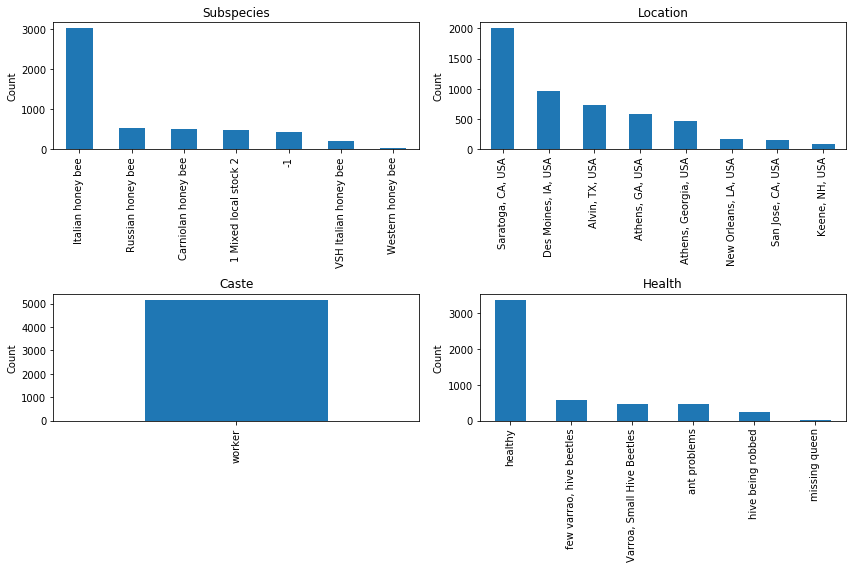

In [5]:
"""
Shown below are four plots plotted using Matplotlib library. 
"""

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
"""
From the firt plot, it cab be inferred that the maximun number of Bees are from "Italian honey bee" species.
"""

Bees.subspecies.value_counts().plot(kind='bar',ax=ax[0, 0])
ax[0,0].set_ylabel('Count')
ax[0,0].set_title('Subspecies')

"""
From the second plot, it can be inferred that the maximum number of images of bees are from Saratoga,CA, USA. 
"""
Bees.location.value_counts().plot(kind='bar', ax=ax[0, 1])
ax[0,1].set_title('Location')
ax[0,1].set_ylabel('Count')

"""
From the third plot, it can be deduced that most the bees from the dataser belong to "Worker" caste
"""

Bees.caste.value_counts().plot(kind='bar', ax=ax[1, 0])
ax[1,0].set_title('Caste')
ax[1,0].set_ylabel('Count')

"""
From the fourth plot, it can be concluded that maximum number of bees are healthy.
"""
Bees.health.value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('Health')
ax[1,1].set_ylabel('Count')
f.tight_layout()

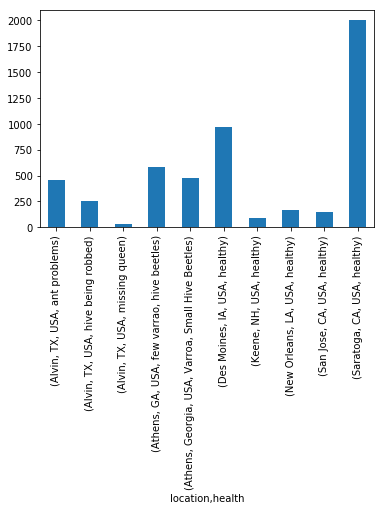

In [6]:
"""
 From the plot below , it can can be concluded that the maximum number of bees that are healthy are from Saratoga,CA,USA
"""
Bees.groupby('location').health.value_counts().plot(kind='bar') 

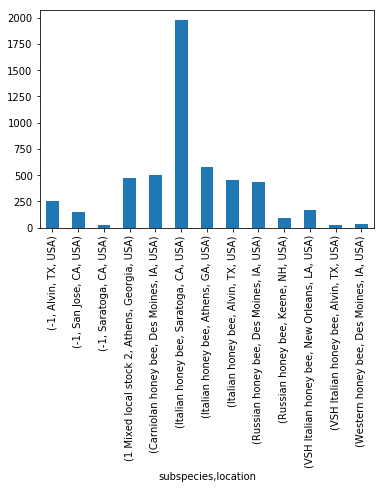

In [7]:
"""
Uknnown species "-1"  are mainly from TX and CA.
"""

Bees.groupby('subspecies').location.value_counts().plot(kind= "bar")

In [8]:
tmp = Bees.groupby('subspecies').health.value_counts()
temp_Bees = pd.DataFrame(data={'Images':tmp.values},index= tmp.index).reset_index()
temp_Bees

,subspecies,health,Images
0,-1,hive being robbed,251
1,-1,healthy,177
2,1 Mixed local stock 2,"Varroa, Small Hive Beetles",472
3,Carniolan honey bee,healthy,501
4,Italian honey bee,healthy,1972
5,Italian honey bee,"few varrao, hive beetles",579
6,Italian honey bee,ant problems,457
7,Russian honey bee,healthy,527
8,VSH Italian honey bee,healthy,170
9,VSH Italian honey bee,missing queen,29


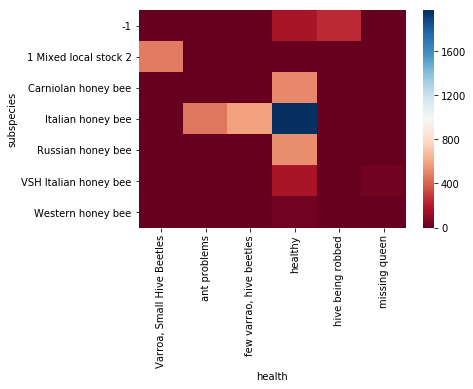

In [9]:
"""
A Heatmap was plotted using Seaborn library between Subspecies and Health
"""

piv = pd.pivot_table(temp_Bees, values="Images",index=["subspecies"], columns=["health"], fill_value=0)
heat_mp = sns.heatmap(piv,cmap= "RdBu")



# Preprocessing of the Data

In [10]:
"""
 Function to read all the images from the folder and resize them to same dimensions
 @param file : file name without full path
 try: Resized the image if present
 except: print the name of the record who's equivalent image is not in the dataset
"""

def read_img(file):
    try:
        img = skimage.io.imread("bee_imgs\\"+ file)
        img = skimage.transform.resize(img, (100,100),mode = 'reflect')
        return img[:,:,:3]
    except:
        print(file)

In [11]:

"""
Applied read_img function to convert each file into its equivalent pixel values
"""
Image = Bees['file'].apply(read_img)


001_043.png


In [12]:
Bees.loc[Bees.file == "001_043.png"]

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
3644,001_043.png,8/25/18,14:00,"Keene, NH, USA",3431,Russian honey bee,healthy,False,worker


In [13]:
"""
Dropped the instance with no equivalent picture in the dataset
"""
Bees.drop(3644,inplace=True)

In [14]:
"""
Shape of the dataset post dropping the record with no equivalent image
"""
Bees.shape

(5171, 9)

In [15]:
"""
Inserted an extra column as Image in the dataset with the respective pixel values
"""

Bees.insert(loc= 9,column= 'Image', value = Image )

In [16]:
"""
Display of the records where subspecies is "-1"
"""
Bees.loc[Bees.subspecies == "-1"].head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,Image
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.8351490196078433, 0.9439372549019608, 0.6..."
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.9685882352941182, 0.9097647058823535, 0.8..."
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.9647254901960789, 0.9921568627450981, 0.8..."
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.9058823529411765, 1.0, 0.7372549019607844..."
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.9098039215686274, 0.8434901960784313, 0.7..."


In [17]:
"""
A new data frame is created "uknown_bees" which has all the instances with subspecies = "-1". It has approximately 428 instances.
"""

unknown_bees = Bees[Bees['subspecies'] == '-1']
unknown_bees.shape

(428, 10)

In [18]:
"""
Removed all the instances with subspecies = "-1" from the original dataset and are stored in the diffrent dataset to use it later for preiction
"""
Bees.drop(Bees.index[Bees.subspecies == '-1'],axis= 0, inplace = True)# removed the species with -1
Bees.shape

(4743, 10)

In [19]:
Bees.subspecies.unique()

array(['Italian honey bee', 'VSH Italian honey bee',
       'Carniolan honey bee', 'Russian honey bee',
       '1 Mixed local stock 2', 'Western honey bee'], dtype=object)

# Model Building CNN 

## Classfication of Subspecies

### Building a model to predict the unknown Subspecies of the Bees "-1"

In [20]:

"""
We took the object which already has an idea of how our neural network is going to be(Sequential).
Then we added a convolution layer by using the “Conv2D” function. 
The Conv2D function is taking 4 arguments, the first is the number of filters i.e 16 here, 
the second argument is the shape each filter is going to be i.e 3x3 here, 
the third is the input shape and the type of image(RGB or Black and White)of each image i.e the input image our CNN is going to be taking is of a 100x100 resolution and “3” stands for RGB, which is a colour img, 
the fourth argument is the activation function we want to use, 
here ‘relu’ stands for a rectifier function.
"""
classifier = Sequential()
classifier.add(Conv2D(16,(3,3), input_shape = (100,100,3), activation = 'relu'))
"""
The primary aim of a pooling operation is to reduce the size of the images as much as possible.
"""
classifier.add(MaxPooling2D())
"""
we are basically doing here is taking the 2-D array, 
i.e pooled image pixels and converting them to a one dimensional single vector.
"""
classifier.add(Flatten())
"""
we need to create a fully connected layer, and to this layer we are going to connect the set of nodes we got after the flattening step, 
these nodes will act as an input layer to these fully-connected layers.
As this layer will be present between the input layer and output layer, we can refer to it a hidden layer.
"""
classifier.add(Dense(units = 150, activation = 'relu'))
"""
initialise our output layer, which should contain only one node, as it is binary classification. 
"""
classifier.add(Dense(units = 6, activation = 'sigmoid'))
"""
Compilation of CNN model
"""
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 38416)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               5762550   
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 906       
Total params: 5,763,904
Trainable params: 5,763,904
Non-trainable params: 0
_________________________________________________________________


# Splitting of Data 

In [21]:
"""
Splitting of the whole data into train and test using sklearn library 
"""
train_df, test_df = train_test_split(Bees,test_size = 0.2 )
"""
Splitting train dataset into train and validation set
"""
train_df, val_df = train_test_split(train_df, test_size=0.05)

In [22]:
"""
Shape of train, test and vaidation set
"""
train_df.shape, test_df.shape, val_df.shape



((3604, 10), (949, 10), (190, 10))

In [23]:
"""
Formulate the data into the format that can be fed into the model for training and testing purposes
"""
x = train_df.Image
train_x =np.stack(x)
train_y = pd.get_dummies(train_df.subspecies)
x_v = val_df.Image
val_x = np.stack(x_v)
val_y = pd.get_dummies(val_df.subspecies)
x_t = test_df.Image
test_x= np.stack(x_t)
test_y = pd.get_dummies(test_df.subspecies)


# Data Augmentation

In [24]:
generator_a= ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)

In [25]:
generator_a.fit(train_x)

In [27]:
"""
fit the training and test data into the model 
"""

training = classifier.fit_generator(generator_a.flow(train_x,train_y),epochs =15,validation_data=[val_x,val_y],steps_per_epoch= 112)


Epoch 1/15
112/112 [==============================] - 35s 313ms/step - loss: 0.1008 - acc: 0.9556 - val_loss: 0.0935 - val_acc: 0.9491
Epoch 2/15
112/112 [==============================] - 35s 309ms/step - loss: 0.0937 - acc: 0.9570 - val_loss: 0.0947 - val_acc: 0.9526
Epoch 3/15
112/112 [==============================] - 35s 311ms/step - loss: 0.0864 - acc: 0.9591 - val_loss: 0.0927 - val_acc: 0.9491
Epoch 4/15
112/112 [==============================] - 35s 308ms/step - loss: 0.0840 - acc: 0.9595 - val_loss: 0.1220 - val_acc: 0.9456
Epoch 5/15
112/112 [==============================] - 34s 307ms/step - loss: 0.0840 - acc: 0.9600 - val_loss: 0.0838 - val_acc: 0.9614
Epoch 6/15
112/112 [==============================] - 35s 309ms/step - loss: 0.0822 - acc: 0.9598 - val_loss: 0.0779 - val_acc: 0.9614
Epoch 7/15
112/112 [==============================] - 34s 308ms/step - loss: 0.0772 - acc: 0.9624 - val_loss: 0.0763 - val_acc: 0.9579
Epoch 8/15
112/112 [==============================] - 3

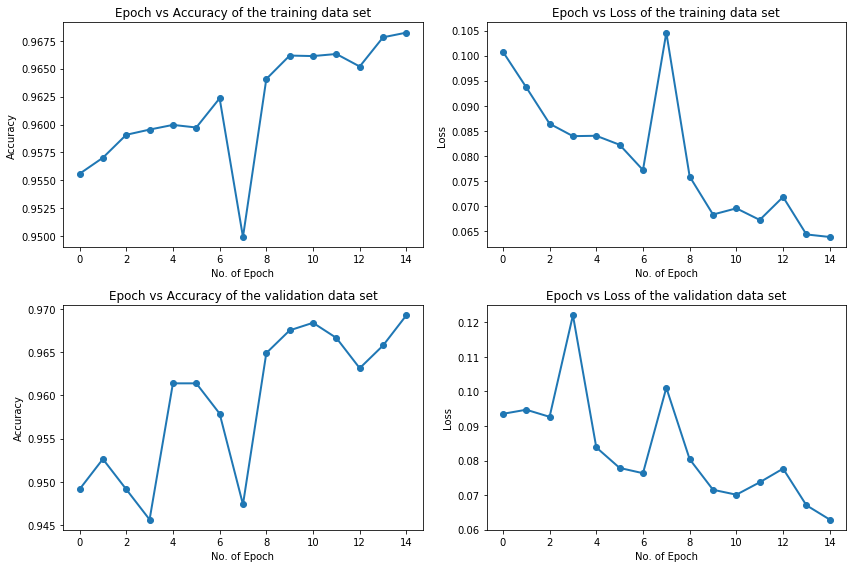

In [28]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
ax[0,0].plot(training.history['acc'],marker = 'o',lw = 2)
ax[0,0].set_title("Epoch vs Accuracy of the training data set")
ax[0,0].set_xlabel('No. of Epoch')
ax[0,0].set_ylabel('Accuracy')
ax[0,1].plot(training.history['loss'],marker = 'o',lw = 2)
ax[0,1].set_title("Epoch vs Loss of the training data set")
ax[0,1].set_xlabel('No. of Epoch')
ax[0,1].set_ylabel('Loss')
ax[1,0].plot(training.history['val_acc'],marker = 'o',lw = 2)
ax[1,0].set_title("Epoch vs Accuracy of the validation data set")
ax[1,0].set_xlabel('No. of Epoch')
ax[1,0].set_ylabel('Accuracy')
ax[1,1].plot(training.history['val_loss'],marker = 'o',lw = 2)
ax[1,1].set_title("Epoch vs Loss of the validation data set")
ax[1,1].set_xlabel('No. of Epoch')
ax[1,1].set_ylabel('Loss')
f.tight_layout()

In [29]:
"""
Testing of the model on the test data.
"""
score = classifier.evaluate(test_x,test_y)

print("Test Loss :",score[0])
print("Test Accuracy :", score[1])


949/949 [==============================] - 3s 3ms/step
Test Loss : 0.055302557742539143
Test Accuracy : 0.975763970104736


# Testing the Model on the data with unknown species '-1'

In [30]:
unknown_bees.head()


,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,Image
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.8351490196078433, 0.9439372549019608, 0.6..."
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.9685882352941182, 0.9097647058823535, 0.8..."
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.9647254901960789, 0.9921568627450981, 0.8..."
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.9058823529411765, 1.0, 0.7372549019607844..."
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.9098039215686274, 0.8434901960784313, 0.7..."


In [31]:
"""
Extracted the "Image" column from the data frame to preprocess it and feed into the model for testing
"""
unknown = unknown_bees.Image
unknown_test = np.stack(unknown)

(array([  5.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 244.,   0.,   0.,
          0.,  52.,   0.,   0.,   0., 110.,   0.,   0.,  17.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <a list of 20 Patch objects>)

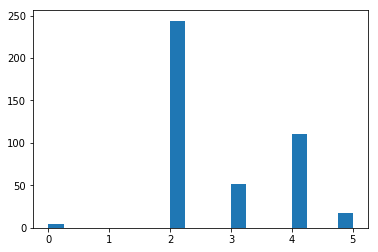

In [32]:
"""
Predicting the classes of the each unknown species image to fall into one of the other six sub-species
"""

subspecies_1 = classifier.predict_classes(unknown_test)
"""
Below we can see the majority of the unclassified images belong to class 2 which is Italian Bee
"""
plt.hist(subspecies_1,bins = 20)


# CNN Model for predicting health of the Bees

## Pre-processing of the Data

In [33]:
health_df = pd.read_csv('bee_data.csv')

In [34]:
health_df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [35]:
a = health_df.file.apply(read_img)

001_043.png


In [36]:
health_df.loc[health_df.file == "001_043.png"]

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
3644,001_043.png,8/25/18,14:00,"Keene, NH, USA",3431,Russian honey bee,healthy,False,worker


In [37]:
health_df.drop(3644,inplace=True)

In [38]:
health_df.insert(loc= 9,column= 'Image', value = a )
health_df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,Image
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.8351490196078433, 0.9439372549019608, 0.6..."
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.9685882352941182, 0.9097647058823535, 0.8..."
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.9647254901960789, 0.9921568627450981, 0.8..."
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.9058823529411765, 1.0, 0.7372549019607844..."
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,"[[[0.9098039215686274, 0.8434901960784313, 0.7..."


## Building Model

In [40]:
classifier_h = Sequential()
classifier_h.add(Conv2D(16,(3,3), input_shape = (100,100,3), activation = 'relu'))
"""
The primary aim of a pooling operation is to reduce the size of the images as much as possible.
"""
classifier_h.add(MaxPooling2D())
"""
we are basically doing here is taking the 2-D array, 
i.e pooled image pixels and converting them to a one dimensional single vector.
"""
classifier_h.add(Flatten())
"""
we need to create a fully connected layer, and to this layer we are going to connect the set of nodes we got after the flattening step, 
these nodes will act as an input layer to these fully-connected layers.
As this layer will be present between the input layer and output layer, we can refer to it a hidden layer.
"""
classifier_h.add(Dense(units = 150, activation = 'relu'))
"""
initialise our output layer, which should contain only one node, as it is binary classification. 
"""
classifier_h.add(Dense(units = 6, activation = 'sigmoid'))
"""
Compilation of CNN model
"""
classifier_h.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier_h.summary()
#test_y_h.columns.size

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 38416)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               5762550   
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 906       
Total params: 5,763,904
Trainable params: 5,763,904
Non-trainable params: 0
_________________________________________________________________


## Splitting of Data

In [41]:
"""
Splitting of the whole data into train and test using sklearn library 
"""
train_df_h, test_df_h = train_test_split(health_df,test_size = 0.2 )
"""
Splitting train dataset into train and validation set
"""
train_df_h, val_df_h = train_test_split(train_df_h, test_size=0.05)

In [42]:
"""
Shape of train, test and vaidation set
"""
train_df_h.shape, test_df_h.shape, val_df_h.shape

((3929, 10), (1035, 10), (207, 10))

In [44]:
"""
Formulate the data into the format that can be fed into the model for training and testing purposes
"""
x_h = train_df_h.Image
train_x_h =np.stack(x_h)
train_y_h = pd.get_dummies(train_df_h.health)
x_v_h = val_df_h.Image
val_x_h = np.stack(x_v_h)
val_y_h = pd.get_dummies(val_df_h.health)
x_t_h = test_df_h.Image
test_x_h= np.stack(x_t_h)
test_y_h = pd.get_dummies(test_df_h.health)


## Data Augmentation

In [45]:
health_generator =ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)

In [46]:
health_generator.fit(train_x_h)

In [48]:
"""
fit the training and test data into the model 
"""

training_h = classifier_h.fit_generator(health_generator.flow(train_x_h,train_y_h),epochs =15,validation_data=[val_x_h,val_y_h],steps_per_epoch= 124)


Epoch 1/15
124/124 [==============================] - 39s 314ms/step - loss: 0.1116 - acc: 0.9505 - val_loss: 0.1212 - val_acc: 0.9501
Epoch 2/15
124/124 [==============================] - 39s 311ms/step - loss: 0.1048 - acc: 0.9533 - val_loss: 0.0953 - val_acc: 0.9565
Epoch 3/15
124/124 [==============================] - 39s 315ms/step - loss: 0.0966 - acc: 0.9540 - val_loss: 0.0873 - val_acc: 0.9541
Epoch 4/15
124/124 [==============================] - 38s 310ms/step - loss: 0.0975 - acc: 0.9551 - val_loss: 0.1215 - val_acc: 0.9493
Epoch 5/15
124/124 [==============================] - 38s 309ms/step - loss: 0.1010 - acc: 0.9543 - val_loss: 0.0860 - val_acc: 0.9581
Epoch 6/15
124/124 [==============================] - 38s 309ms/step - loss: 0.0863 - acc: 0.9591 - val_loss: 0.0748 - val_acc: 0.9605
Epoch 7/15
124/124 [==============================] - 39s 313ms/step - loss: 0.0805 - acc: 0.9626 - val_loss: 0.0699 - val_acc: 0.9654
Epoch 8/15
124/124 [==============================] - 3

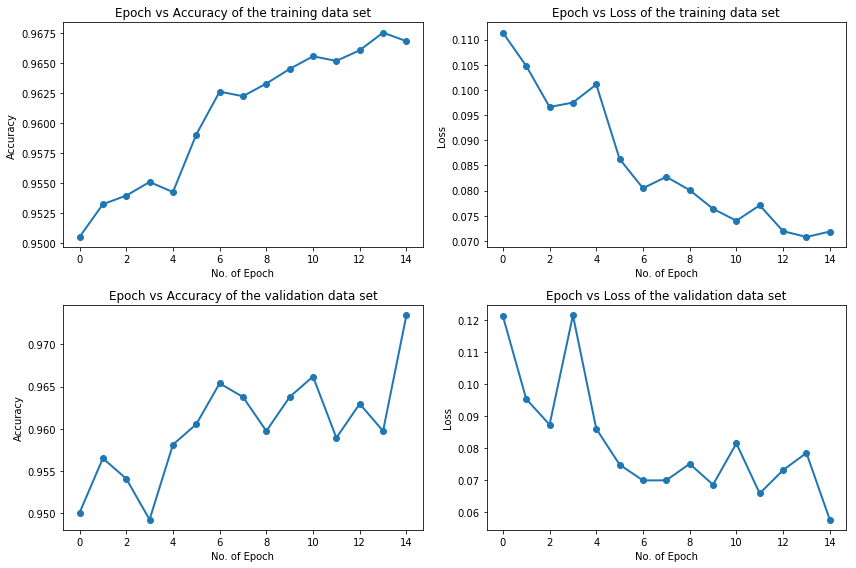

In [49]:
f_h, ax_h = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
ax_h[0,0].plot(training_h.history['acc'],marker = 'o',lw = 2)
ax_h[0,0].set_title("Epoch vs Accuracy of the training data set")
ax_h[0,0].set_xlabel('No. of Epoch')
ax_h[0,0].set_ylabel('Accuracy')
ax_h[0,1].plot(training_h.history['loss'],marker = 'o',lw = 2)
ax_h[0,1].set_title("Epoch vs Loss of the training data set")
ax_h[0,1].set_xlabel('No. of Epoch')
ax_h[0,1].set_ylabel('Loss')
ax_h[1,0].plot(training_h.history['val_acc'],marker = 'o',lw = 2)
ax_h[1,0].set_title("Epoch vs Accuracy of the validation data set")
ax_h[1,0].set_xlabel('No. of Epoch')
ax_h[1,0].set_ylabel('Accuracy')
ax_h[1,1].plot(training_h.history['val_loss'],marker = 'o',lw = 2)
ax_h[1,1].set_title("Epoch vs Loss of the validation data set")
ax_h[1,1].set_xlabel('No. of Epoch')
ax_h[1,1].set_ylabel('Loss')
f_h.tight_layout()

In [50]:
"""
Testing of the model on the test data.
"""
score_h = classifier_h.evaluate(test_x_h,test_y_h)

print("Test Loss :",score[0])
print("Test Accuracy :", score[1])

1035/1035 [==============================] - 3s 3ms/step
Test Loss : 0.055302557742539143
Test Accuracy : 0.975763970104736


(array([134.,   0.,   0.,   0.,  95.,   0.,   0.,   0.,  74.,   0.,   0.,
          0., 687.,   0.,   0.,   0.,  39.,   0.,   0.,   6.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <a list of 20 Patch objects>)

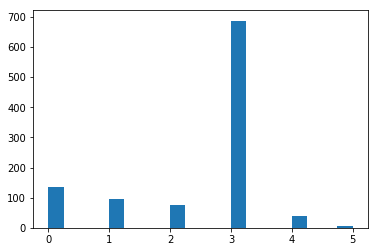

In [51]:
"""
Predicting the classes of the each Bee image to fall into one of the other six sub- categories of health 
"""

health_sub = classifier_h.predict_classes(test_x_h)
"""
Below we can see the majority of the unclassified images belong to class 4 which is Healthy Bees
"""
plt.hist(health_sub,bins = 20)


# Conclusion

#### We built two CNN models for predicting the sub species of Bees and health with the help of Image classification
* Model 1: Classification of sub-species of Bees
* A CNN model was bulit with an accuracy of 96.7% to predict the sub species with the help of Image of the Bee
* Model 2: Classification of health status of Bees
* Another CNN model was bulit to predict the status of the health just with the help of the Image of the Bee. We were able to acheive a model with the accuracy of 95%.

# Business Used Cases

* Companies like Bee Corp and Apis Protect are working on decision support software that would monitor condition inside the beehives, focusing on utilizing commoditized IoT sensors. 
* The analysis on Image data would further help the companies mentioned above to acheive the common goal of protecting the bees and preserving the eco-system  .